In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from gpflow.kernels import Matern52
from gpflow.models import GPR
from gpflow.utilities import set_trainable

from robust_smc.kalman import Kalman
from robust_smc.sampler import LinearGaussianBPF, RobustifiedLinearGaussianBPF
from robust_smc.smoother import LinearGaussianSmoother
from robust_smc.state_space_kernels import StateSpaceMatern52

%matplotlib inline

In [2]:
step = 2
num_train = 100
X = np.linspace(0, 100, step * num_train)[:, None]
kernel = Matern52(lengthscale=5.0, variance=10.)
K = kernel(X).numpy()
L = np.linalg.cholesky(K)
epsilon = np.random.randn(X.shape[0], 1)
Y = np.matmul(L, epsilon)
noise_std = 1.0

In [3]:
X_train, Y_train = X[::step].copy(), Y[::step].copy() 
Y_train += noise_std * np.random.randn(Y_train.shape[0], 1)
Y_missing = np.full_like(Y, np.nan)
Y_missing[::step] = Y_train.copy()

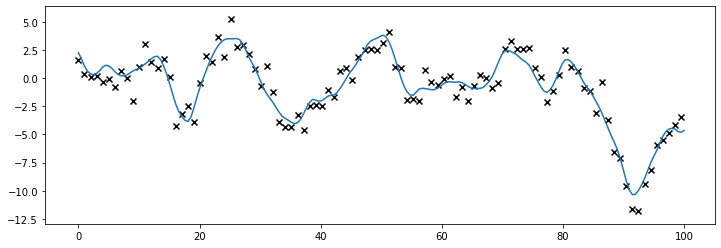

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(X, Y)
plt.scatter(X_train, Y_train, marker='x', color='k');

## Batch GP model

In [5]:
def make_batch_gp_model():
    kernel = Matern52(lengthscale=5.0, variance=10.)
    set_trainable(kernel, False)
    model = GPR((X_train, Y_train), kernel=kernel, noise_variance=noise_std ** 2)
    set_trainable(model.likelihood, False)
    return model

In [6]:
batch_model = make_batch_gp_model()

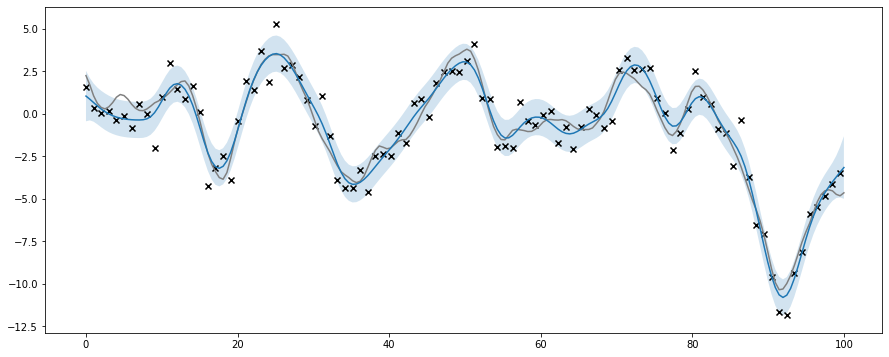

In [7]:
mean, var = batch_model.predict_f(X)
plt.figure(figsize=(15, 6))
plt.plot(X, Y, color='gray')
plt.plot(X, mean)
plt.fill_between(X[:, 0], mean[:, 0] - 1.96 * np.sqrt(var)[:, 0],
                 mean[:, 0] + 1.96 * np.sqrt(var)[:, 0], alpha=0.2)
plt.scatter(X_train, Y_train, marker='x', color='k');

## SS GP model

In [8]:
ss_kernel = StateSpaceMatern52(lengthscale=5.0, variance=10.)

In [9]:
delta = 1.0
A, Q, H, m_0, P_0 = ss_kernel.discretize(delta=delta / step)

In [10]:
kalman = Kalman(data=Y_missing, transition_matrix=A, transition_cov=Q, 
                observation_matrix=H, observation_cov=noise_std ** 2, m_0=m_0, P_0=P_0)

In [11]:
kalman.filter()

100%|██████████| 200/200 [00:00<00:00, 23210.78it/s]


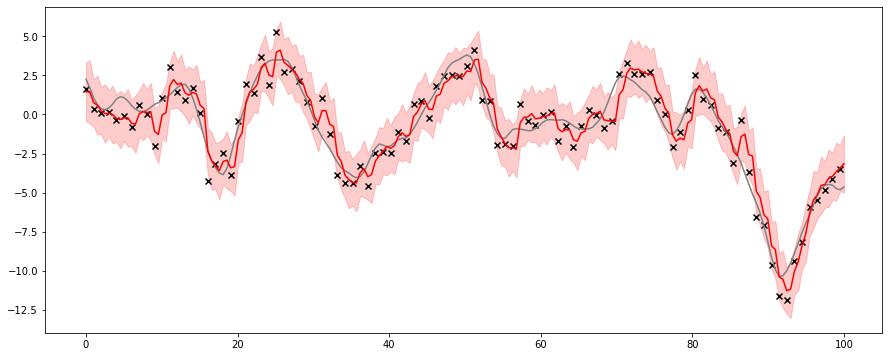

In [12]:
traj = np.stack(kalman.filter_means)
uncertainty =  np.stack([np.diagonal(P) for P in kalman.filter_covs])
var = 0

plt.figure(figsize=(15, 6))

mean = traj[:, var, 0]
std = np.sqrt(uncertainty[:, var])
plt.plot(X, Y, color='gray')
plt.plot(X, mean, c='r')
plt.fill_between(X[:, 0], mean - 1.96 * std, mean + 1.96 * std, alpha=0.2, color='r')
plt.scatter(X_train, Y_train, marker='x', color='k');

In [13]:
kalman.smooth()

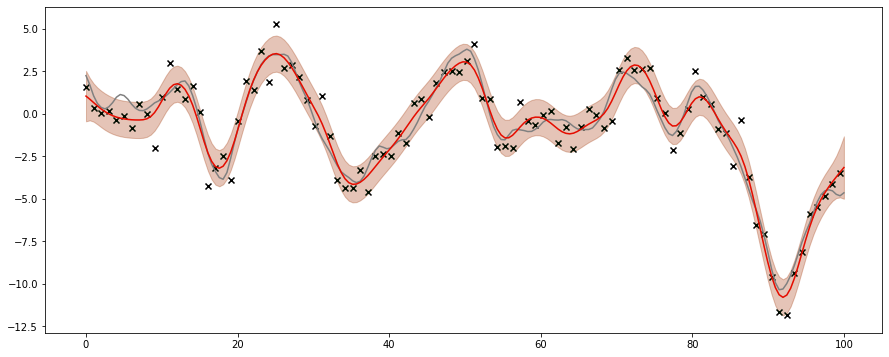

In [14]:
traj = np.stack(kalman.smoother_means)
uncertainty =  np.stack([np.diagonal(P) for P in kalman.smoother_covs])
var = 0

plt.figure(figsize=(15, 6))

mean = traj[:, var, 0]
std = np.sqrt(uncertainty[:, var])
plt.plot(X, Y, color='gray')
plt.plot(X[:, 0], mean, c='r')
plt.fill_between(X[:, 0], mean - 1.96 * std, mean + 1.96 * std, alpha=0.2, color='r')
plt.scatter(X_train, Y_train, marker='x', color='k');


mean, var = batch_model.predict_f(X)
plt.plot(X, mean, color='g', alpha=0.1)
plt.fill_between(X[:, 0], mean[:, 0] - 1.96 * np.sqrt(var)[:, 0],
                 mean[:, 0] + 1.96 * np.sqrt(var)[:, 0], alpha=0.1, color='g')

##  BPF Approximation

In [15]:
num_samples = 1000
L_0 = np.linalg.cholesky(P_0)
x_init = m_0 + L_0[None, :, :] @ np.random.randn(num_samples, 3, 1)
x_init = x_init[:, :, 0]
sampler = LinearGaussianBPF(Y_missing, A, Q, x_init=x_init, 
                            observation_model=lambda x: (H[None, :, :] @ x[:, :, None])[:, :, 0], 
                            noise_cov=noise_std ** 2, num_samples=num_samples)

In [16]:
sampler.sample()

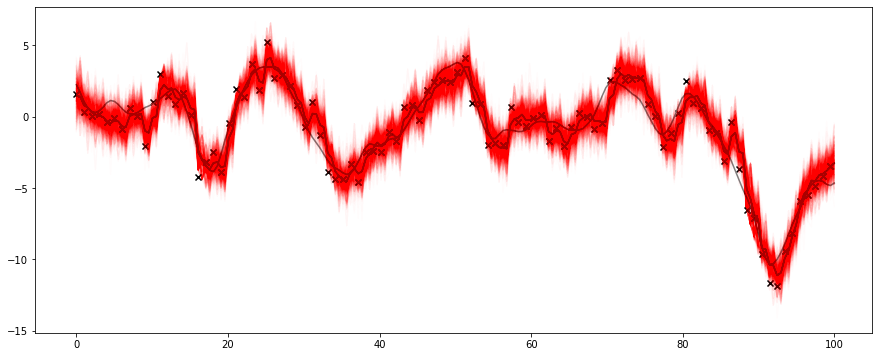

In [17]:
traj = np.stack(sampler.x_trajectories)
var = 0

plt.figure(figsize=(15, 6))
mean = traj[:, :, var].mean(axis=1)
plt.plot(X, Y, color='gray')
plt.plot(X, mean, c='k', alpha=0.8, ls='-')
for i in range(num_samples):
#     plt.scatter(X, traj[:, i, var], c='r', alpha=0.01, ls='-')
    plt.plot(X, traj[:, i, var], c='r', alpha=0.01, ls='-')

plt.scatter(X_train, Y_train, marker='x', color='k');

Text(0.5, 1.0, 'Effective sample size with time')

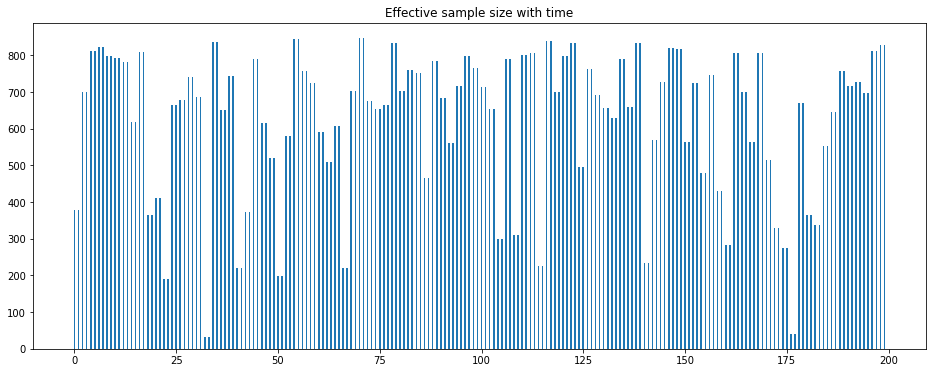

In [18]:
ess = [sampler.effective_sample_size(logw) for logw in sampler.logw]

plt.figure(figsize=(16, 6))
plt.bar(range(len(ess)), ess, width=0.4)
plt.title('Effective sample size with time')
# plt.ylim((600, 1000));

In [19]:
smoother = LinearGaussianSmoother(sampler, 1000)

In [20]:
smoother.sample_smooth_trajectories()

100%|██████████| 199/199 [01:10<00:00,  2.82it/s]


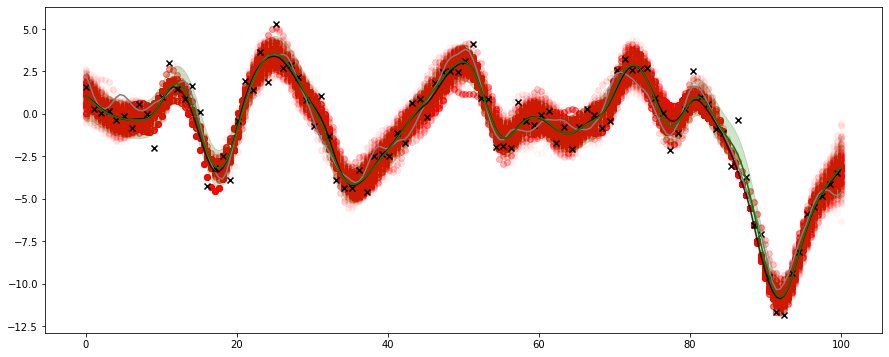

In [21]:
plt.figure(figsize=(15, 6))
var = 0
mean = smoother.smoother_samples[:, :, var].mean(axis=1)
plt.plot(X, Y, color='gray')
plt.plot(X, mean, c='k', alpha=0.8, ls='-')
for i in range(smoother.num_samples):
    plt.scatter(X, smoother.smoother_samples[:, i, var], c='r', alpha=0.01, ls='-')
#     plt.plot(traj[:, i, var], c='r', alpha=0.01, ls='-')
mean, var = batch_model.predict_f(X)
plt.plot(X, mean, color='g')
plt.fill_between(X[:, 0], mean[:, 0] - 1.96 * np.sqrt(var)[:, 0],
                 mean[:, 0] + 1.96 * np.sqrt(var)[:, 0], alpha=0.2, color='g')
plt.scatter(X_train, Y_train, marker='x', color='k');

## Robust BPF

In [22]:
num_samples = 1000
L_0 = np.linalg.cholesky(P_0)
x_init = m_0 + L_0[None, :, :] @ np.random.randn(num_samples, 3, 1)
x_init = x_init[:, :, 0]
sampler = RobustifiedLinearGaussianBPF(Y_missing, 0.1, A, Q, x_init=x_init, 
                            observation_model=lambda x: (H[None, :, :] @ x[:, :, None])[:, :, 0], 
                            noise_cov=noise_std ** 2, num_samples=num_samples)

In [23]:
sampler.sample()

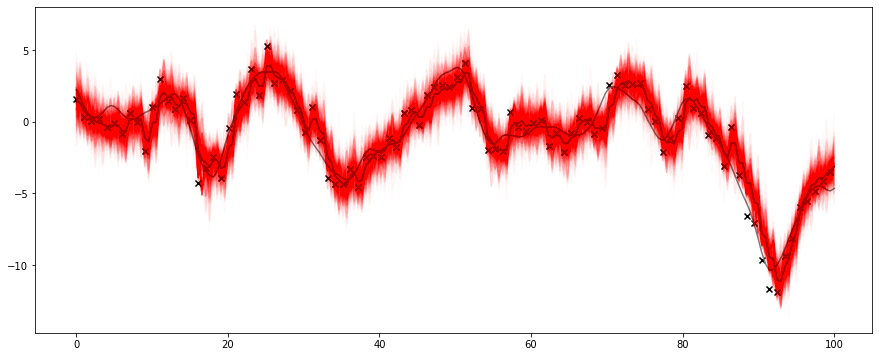

In [24]:
traj = np.stack(sampler.x_trajectories)
var = 0

plt.figure(figsize=(15, 6))
mean = traj[:, :, var].mean(axis=1)
plt.plot(X, Y, color='gray')
plt.plot(X, mean, c='k', alpha=0.8, ls='-')
for i in range(num_samples):
#     plt.scatter(X, traj[:, i, var], c='r', alpha=0.01, ls='-')
    plt.plot(X, traj[:, i, var], c='r', alpha=0.01, ls='-')

plt.scatter(X_train, Y_train, marker='x', color='k');

Text(0.5, 1.0, 'Effective sample size with time')

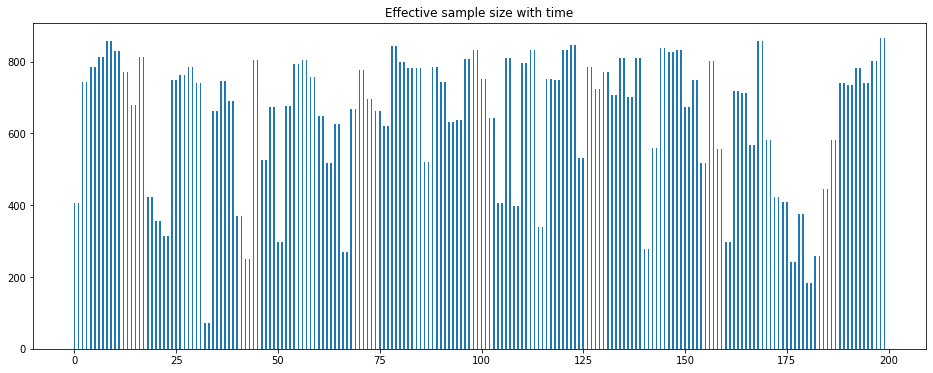

In [25]:
ess = [sampler.effective_sample_size(logw) for logw in sampler.logw]

plt.figure(figsize=(16, 6))
plt.bar(range(len(ess)), ess, width=0.4)
plt.title('Effective sample size with time')
# plt.ylim((600, 1000));

In [26]:
smoother = LinearGaussianSmoother(sampler, 1000)

In [27]:
smoother.sample_smooth_trajectories()

100%|██████████| 199/199 [01:11<00:00,  2.79it/s]


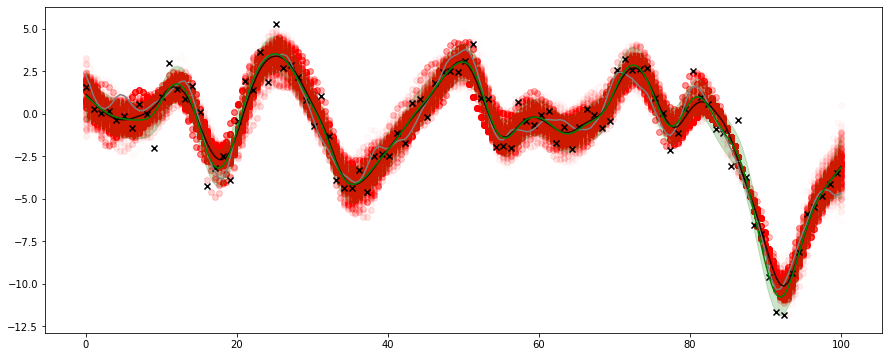

In [28]:
plt.figure(figsize=(15, 6))
var = 0
mean = smoother.smoother_samples[:, :, var].mean(axis=1)
plt.plot(X, Y, color='gray')
plt.plot(X, mean, c='k', alpha=0.8, ls='-')
for i in range(smoother.num_samples):
    plt.scatter(X, smoother.smoother_samples[:, i, var], c='r', alpha=0.01, ls='-')
#     plt.plot(traj[:, i, var], c='r', alpha=0.01, ls='-')
mean, var = batch_model.predict_f(X)
plt.plot(X, mean, color='g')
plt.fill_between(X[:, 0], mean[:, 0] - 1.96 * np.sqrt(var)[:, 0],
                 mean[:, 0] + 1.96 * np.sqrt(var)[:, 0], alpha=0.2, color='g')
plt.scatter(X_train, Y_train, marker='x', color='k');